In [2]:
from sklearn import decomposition
import seaborn as sn

In [17]:
# general purpose libraries
import numpy as np
import datetime as dt
import pandas as pd
import os
import warnings
import pickle
from timeit import default_timer as timer
from collections import OrderedDict
from itertools import chain

from tqdm.notebook import tqdm
from scipy.signal import hilbert

import json

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )


In [4]:
from audio2numpy import open_audio

In [4]:
# DSP libraries
from scipy import signal
import librosa
import librosa.display as librosa_display

In [5]:
### Setup paths and directories
work_dir = r'dataset/' 
data_dir = work_dir + r"COUGHVID/"
raw_data_dir = data_dir + r"raw/"
audio_outdir = "out"

metadata_file = "metadata_compiled.csv"

In [6]:
metadata=pd.read_csv(data_dir+metadata_file,sep=",")
#print(metadata.columns)

# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(),c] = metadata.loc[metadata[c].notnull(),c].astype(bool) 

# remove entries where either status or age is NA
print("Metadata df entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) ),]
print("Metadata df entries after cleaning NAs: {}".format(metadata.shape[0]))



Metadata df entries before cleaning NAs: 27550
Metadata df entries after cleaning NAs: 15218


In [7]:
metadata['audio_class'] = 'X' # default, we should have none by the end of this classification process
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "COVID-19") ,'audio_class'] = 1
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "healthy") ,'audio_class'] = 0
# metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['status'] == "symptomatic") ,'audio_class'] = 0

print("Entries subdivided in classes. Printing the number of entries for each class:")
print(metadata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

print("\n\n\nSplitting count by class and status:")
print(metadata[['audio_class','status','uuid']].groupby(['audio_class','status']).count().rename(columns={'uuid':'N_entries'}) )


Entries subdivided in classes. Printing the number of entries for each class:
             N_entries
audio_class           
0                 7905
1                  608
X                 6705



Splitting count by class and status:
                         N_entries
audio_class status                
0           healthy           7905
1           COVID-19           608
X           COVID-19           357
            healthy           3827
            symptomatic       2521


In [8]:
validdata = metadata.loc[(metadata['audio_class'] != 'X')]
print(validdata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                 7905
1                  608


In [9]:
# Balance the number of each classes
num = len(validdata.loc[validdata["audio_class"] == 1])
balanced_data = pd.concat([
    validdata.loc[validdata["audio_class"] == 1],
    validdata.loc[validdata["audio_class"] == 0].sample(n = num)
])

In [10]:
print(balanced_data[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                  608
1                  608


In [13]:
signals = []
labels = []

for uuid, label in tqdm(zip(balanced_data["uuid"].values, balanced_data["audio_class"].values), total = len(balanced_data)):
    filename = uuid + ".webm"
    if not os.path.exists(raw_data_dir + filename):
        # try to look for a .ogg file
        filename = uuid + ".ogg"
        if not os.path.exists(raw_data_dir + filename):
            print(f"could not find audio file for uuid: {uuid}")
            continue

    file_path = os.path.join(raw_data_dir, filename)
    # print(file_path)
    signal, sr = librosa.load(file_path, sr = None)
    signals.append(signal)
    labels.append(label)

  0%|          | 0/1216 [00:00<?, ?it/s]

dataset/COUGHVID/raw/015576c8-2b03-4dcb-b251-78a984fe86fe.webm
dataset/COUGHVID/raw/0177b817-0ba3-498a-bc05-48bc66cc91b8.webm
dataset/COUGHVID/raw/01820f7c-b953-4faf-aa13-978cfda6b08e.webm
dataset/COUGHVID/raw/01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.webm
dataset/COUGHVID/raw/02aa80ef-a83b-477f-b01d-575651364b22.webm
dataset/COUGHVID/raw/031fd54a-87b5-4223-9af6-60985127fb7a.webm
dataset/COUGHVID/raw/033da4e3-7365-4adc-9252-7347816e4e77.webm
dataset/COUGHVID/raw/0379c586-c500-483c-83a6-95b63afe6931.webm
dataset/COUGHVID/raw/03d30b8b-03f8-4089-bda8-0e14deec7d82.webm
dataset/COUGHVID/raw/0640716b-e287-4181-a653-5b798e8308c8.webm
dataset/COUGHVID/raw/06b568b5-b9f8-4334-816c-c16009bb5de7.webm
dataset/COUGHVID/raw/06b58ff7-42e9-49d8-8b56-dd82e7b18ace.webm
dataset/COUGHVID/raw/0762cd0a-5ce6-4b1b-9374-5d4396c218ed.webm
dataset/COUGHVID/raw/080b6119-f1ab-4337-93dd-aaccf73b4ee1.webm
dataset/COUGHVID/raw/082991fb-ee66-4970-91dd-50890f4cc9b1.webm
dataset/COUGHVID/raw/09115490-33a9-461c-9437-d7f71be057

In [24]:
signal_lengths = np.asarray([len(signal) for signal in signals])

(array([  6.,  46.,  87., 116.,  86.,  68., 133., 672.,   0.,   2.]),
 array([ 51840., 110304., 168768., 227232., 285696., 344160., 402624.,
        461088., 519552., 578016., 636480.]),
 <BarContainer object of 10 artists>)

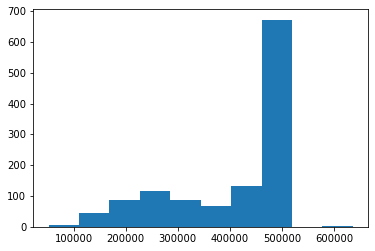

In [25]:
plt.hist(signal_lengths)

In [29]:
np.sum(signal_lengths > 300000) / signal_lengths.shape[0]

0.772203947368421

In [31]:
fix_length = 300000
signals_fix = [librosa.util.fix_length(signal, size = fix_length) for signal in signals]

In [36]:
signals_fix = np.asarray(signals_fix)

In [37]:
signals_fix.shape

(1216, 300000)

In [70]:
pca = decomposition.PCA()

shape of pca_reduced.shape = (1216, 30)
[0.00757489 0.00645378 0.00634982 0.00610436 0.00596379 0.00572251
 0.00558559 0.0052794  0.00524294 0.00514352 0.00492618 0.00482816
 0.00478211 0.00476123 0.00470972 0.00448858 0.00413987 0.00400721
 0.00390127 0.00384555 0.00381088 0.00378077 0.00370002 0.00362545
 0.00352228 0.00345654 0.00340141 0.00335321 0.00330259 0.00328836]


Text(0.5, 1.0, 'PCA explained variance ratio')

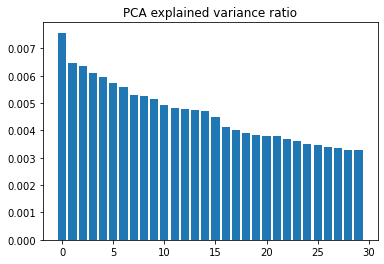

In [74]:
pca.n_components = 30
pca_data = pca.fit_transform(signals_fix)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

In [76]:
pca.n_components = 2
pca_data = pca.fit_transform(signals_fix)
#pca reduced will contain the 2d projects of simple data
print("shape of pca_reduced.shape =", pca_data.shape)


shape of pca_reduced.shape = (1216, 2)


d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


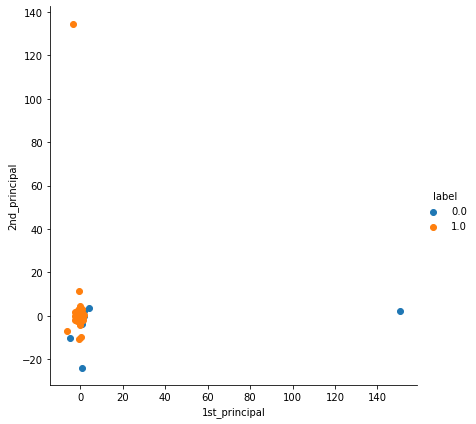

In [77]:
pca_data = np.vstack((pca_data.T, labels)).T

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

In [45]:
np.argmax(pca_data[:, 1])

340

In [44]:
pca_data[698, 0]

150.3647003173828

In [46]:
pca_data[340, 1]

133.24795532226562

In [48]:
pca_new = np.delete(pca_data, [340, 698], axis = 0)

In [49]:
pca_new.shape

(1214, 3)

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


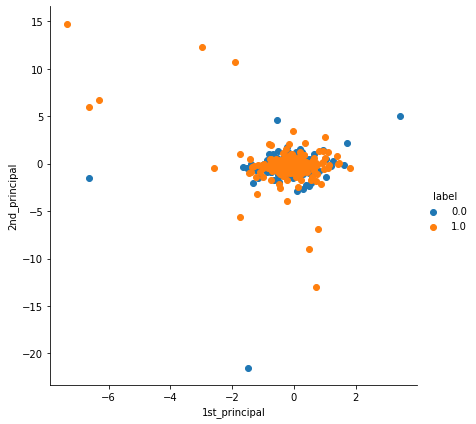

In [50]:
pca_df_new = pd.DataFrame(data = pca_new, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df_new, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

In [57]:
balanced_data["uuid"].values[[340, 698, 500]]

array(['9031d3b2-4019-403f-9c71-f387e6b60a82',
       '35cdb63c-cc79-46b6-b052-c144ff1dd138',
       'd2a55629-24e2-4460-8a0a-b7065927ee07'], dtype=object)

# Russian dataset

In [6]:
# Set dataset path
datasetPath = r"dataset/Russian-dataset"
rawDataPath = os.path.join(datasetPath, "raw")

In [7]:
data = {
  "filename": [],
  "signal": [],
  "covid": []
}

In [8]:
#Read Dataset
with open(os.path.join(datasetPath, 'metadata.json')) as f:
  datalist = json.load(f)
  
#Feature extraction

for key in tqdm(datalist):

  if 'filename' not in key:
    continue

  if 'covid19' not in key or 'verified' not in key or int(key['covid19']) != int(key['verified']):
    continue

  filename = key['filename']
  try:
    filepath = os.path.join(rawDataPath, filename)
    signal, sampleRate = open_audio(filepath)
    
    if len(signal.shape) != 1:
      signal = np.mean(signal, axis = 1)

    if sampleRate != 8000:
      signal = librosa.resample(signal, sampleRate, 8000)

  except:
    print(0)
    continue

  data["covid"].append(int(key['covid19']))
  data["filename"].append(filename)
  data["signal"].append(signal)



  0%|          | 0/1324 [00:00<?, ?it/s]

<ipython-input-8-e15ec81aed5d>:24: FutureWarning: Pass orig_sr=48000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal = librosa.resample(signal, sampleRate, 8000)


0


In [9]:
import pickle
with open(os.path.join(datasetPath, "verified.pkl"), "wb") as f:
    pickle.dump(data, f)

In [10]:
with open(os.path.join(datasetPath, "verified.pkl"), "rb") as f:
    data = pickle.load(f)

In [11]:
signal_lengths = np.asarray([len(signal) for signal in data["signal"]])

(array([560., 193.,  36.,  11.,   5.,   3.,   2.,   2.,   5.,   1.]),
 array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000., 200000.]),
 <BarContainer object of 10 artists>)

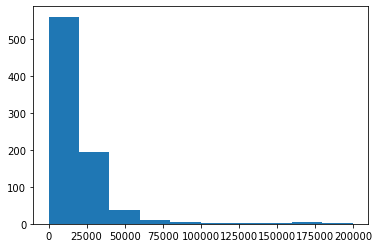

In [12]:
plt.hist(signal_lengths, range = (0, 200000))

In [13]:
np.sum(signal_lengths > 10000) / signal_lengths.shape[0]

0.7655677655677655

In [15]:
fix_length = 10000
signals_fix = [librosa.util.fix_length(signal, size = fix_length) for signal in data["signal"]]

In [17]:
signals_fix = np.asarray(signals_fix)
signals_fix.shape

(819, 10000)

In [18]:
pca = decomposition.PCA()

Text(0.5, 1.0, 'PCA explained variance ratio')

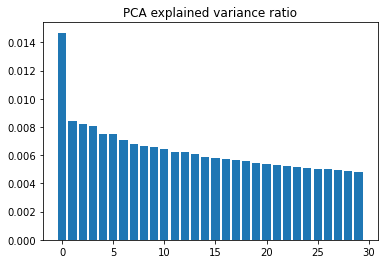

In [19]:
pca.n_components = 30
pca_data = pca.fit_transform(signals_fix)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

In [30]:
pca.n_components = 2
pca_data = pca.fit_transform(signals_fix)
#pca reduced will contain the 2d projects of simple data
print("shape of pca_reduced.shape =", pca_data.shape)


shape of pca_reduced.shape = (819, 2)


d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


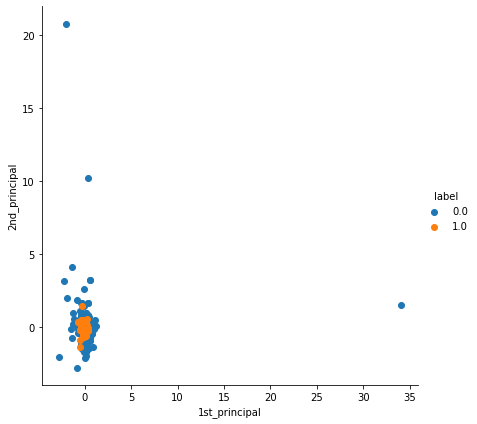

In [22]:
pca_data = np.vstack((pca_data.T, data["covid"])).T

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

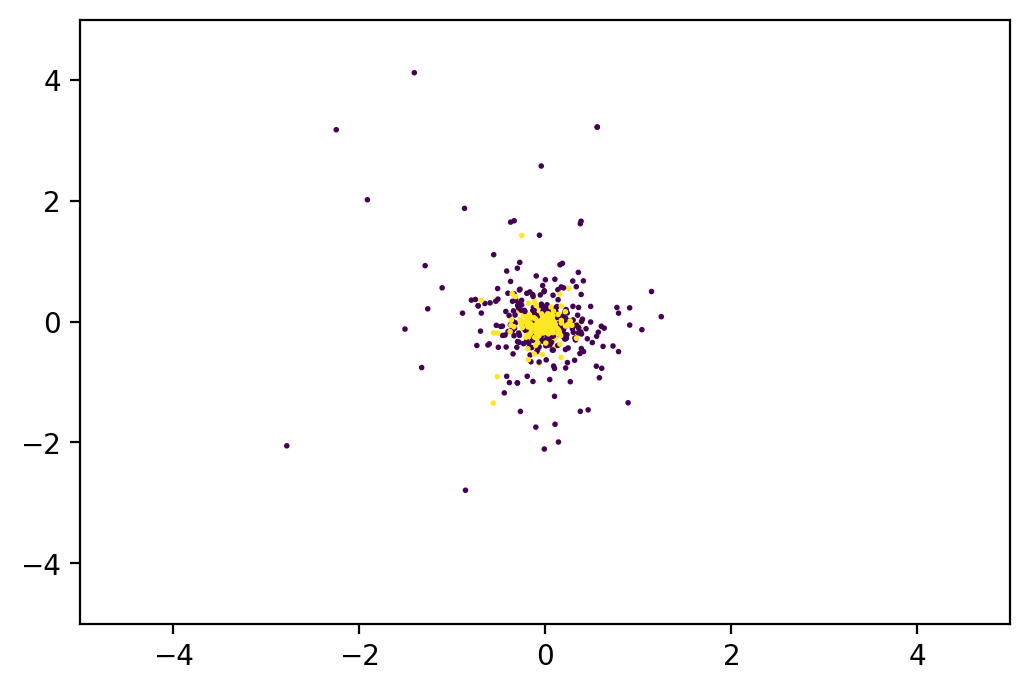

In [28]:
plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = data["covid"], s = 1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [31]:
pca.n_components = 3
pca_data = pca.fit_transform(signals_fix)
#pca reduced will contain the 2d projects of simple data
print("shape of pca_reduced.shape =", pca_data.shape)


shape of pca_reduced.shape = (819, 3)


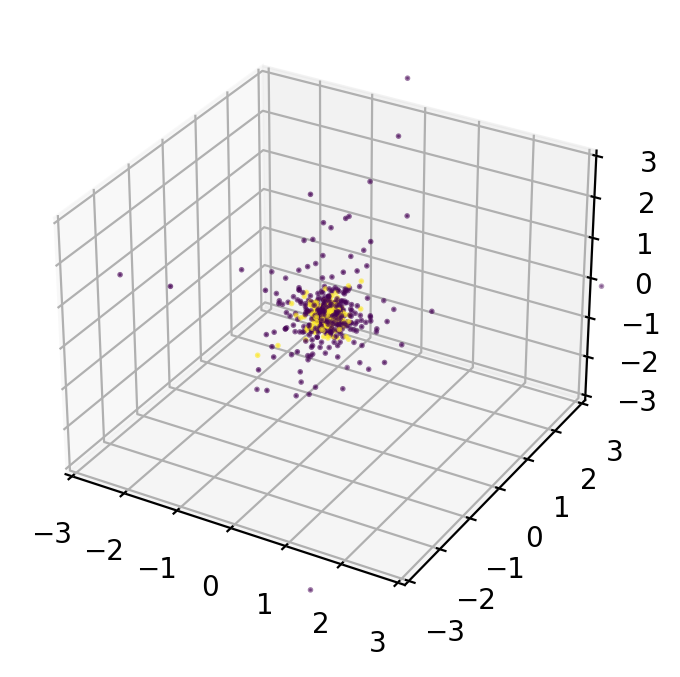

In [35]:
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c = data["covid"], s = 1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3) 
plt.show()

PCA of MFCC (russian dataset)

In [47]:
# Set dataset path
datasetPath = r"dataset/Russian-dataset"
rawDataPath = os.path.join(datasetPath, "raw")

In [48]:
mfcc = np.load(os.path.join(datasetPath, "mfcc_300000_resampled.npy"))
labels = np.load(os.path.join(datasetPath, "covid_status.npy"))

In [49]:
mfcc_reshaped = mfcc.reshape(819, -1)

Text(0.5, 1.0, 'PCA explained variance ratio')

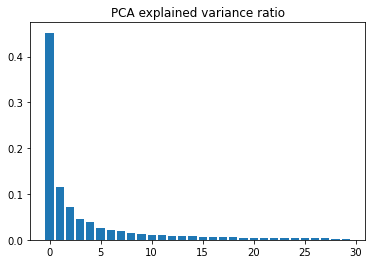

In [50]:
pca.n_components = 30
pca_data = pca.fit_transform(mfcc_reshaped)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

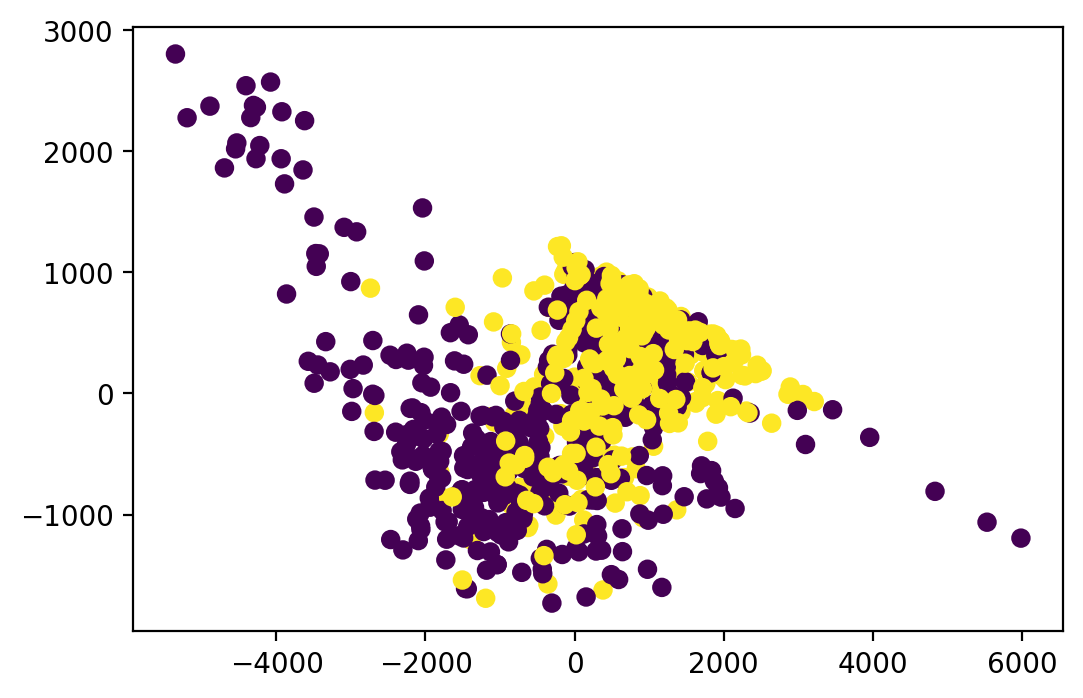

In [51]:
pca.n_components = 2
pca_data = pca.fit_transform(mfcc_reshaped)

plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = labels)
plt.show()

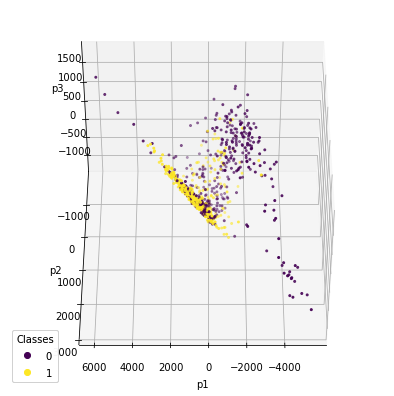

In [74]:
pca.n_components = 3
pca_data = pca.fit_transform(mfcc_reshaped)

fig = plt.figure(figsize = (8, 7))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c = labels, s = 4)
ax.set_xlabel("p1")
ax.set_ylabel("p2")
ax.set_zlabel("p3")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.view_init(45, 90)

plt.show()

PCA of 1s activity signal (COUGHVID)

In [50]:
### Setup paths and directories
dataset_path = r"dataset/COUGHVID/preprocess2/"
rawdata_path = os.path.join(dataset_path, "raw")
metadata_path = os.path.join(dataset_path, "metadata.csv")

In [51]:
metadata = pd.read_csv(metadata_path, sep = ",")

In [53]:
print(metadata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                  686
1                  691


In [55]:
data = {
    "filename": [],
    "signal": [],
    "label": []
}

for uuid, audio_class in tqdm(zip(metadata["uuid"].values, metadata["audio_class"].values), total = len(metadata)):

    filename = uuid + ".wav"
    file_path = os.path.join(rawdata_path, filename)

    if not os.path.exists(file_path):
        print(f"could not find audio file for uuid: {uuid}")
        continue

    signal, sr = librosa.load(file_path, sr = None)

    data["signal"].append(signal)
    data["label"].append(audio_class)
    data["filename"].append(uuid)


  0%|          | 0/1377 [00:00<?, ?it/s]

In [67]:
with open(os.path.join(dataset_path, "signals.pkl"), "wb") as f:
    pickle.dump(data, f)

In [57]:
signals = np.asarray(data["signal"])

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [65]:
signals_fix = [librosa.util.fix_length(signal, size = 48000) for signal in data["signal"]]

In [66]:
data["signal"] = signals_fix

In [68]:
signals = np.asarray(data["signal"])

In [69]:
signals.shape

(1377, 48000)

Text(0.5, 1.0, 'PCA explained variance ratio')

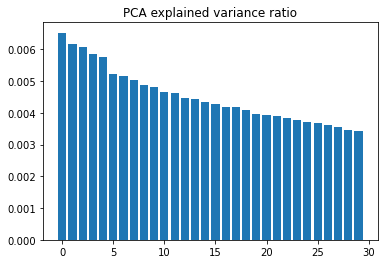

In [71]:
pca.n_components = 30
pca_data = pca.fit_transform(signals)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

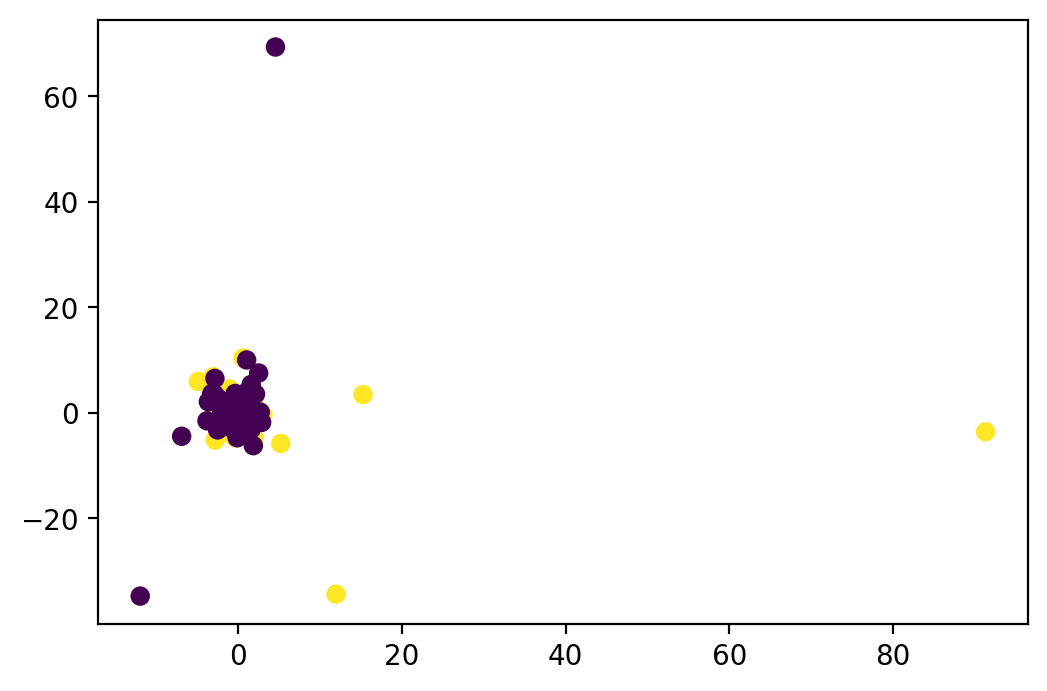

In [73]:
pca.n_components = 2
pca_data = pca.fit_transform(signals)

plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = data["label"])
plt.show()

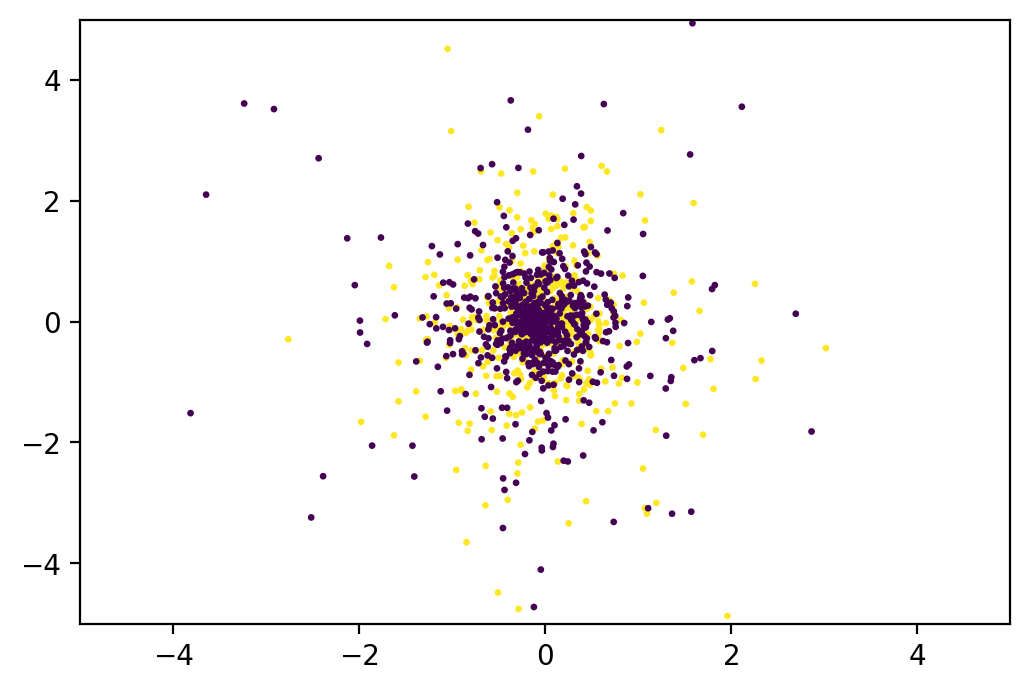

In [76]:
plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = data["label"], s = 2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

PCA of MFCC (COUGHVID)

In [ ]:
### Setup paths and directories
dataset_path = r"dataset/COUGHVID/preprocess4/"
rawdata_path = os.path.join(dataset_path, "raw")
metadata_path = os.path.join(dataset_path, "metadata.csv")

: 

In [15]:
with open(os.path.join(dataset_path, "mfcc_fixlength_48000_nmfcc_15_nfft_1024_hoplength_512.pkl"), "rb") as f:
    mfcc = pickle.load(f)

In [16]:
mfccs = []
labels = []
for mfcc, label in list(mfcc.values()):
    mfccs.append(mfcc)
    labels.append(label)

In [17]:
mfccs = np.asarray(mfccs)

In [20]:
mfccs_reshaped = mfccs.reshape(mfccs.shape[0], -1)

In [22]:
pca = decomposition.PCA()

Text(0.5, 1.0, 'PCA explained variance ratio')

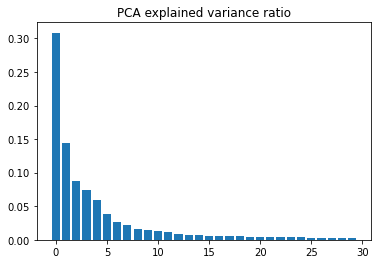

In [23]:
pca.n_components = 30
pca_data = pca.fit_transform(mfccs_reshaped)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

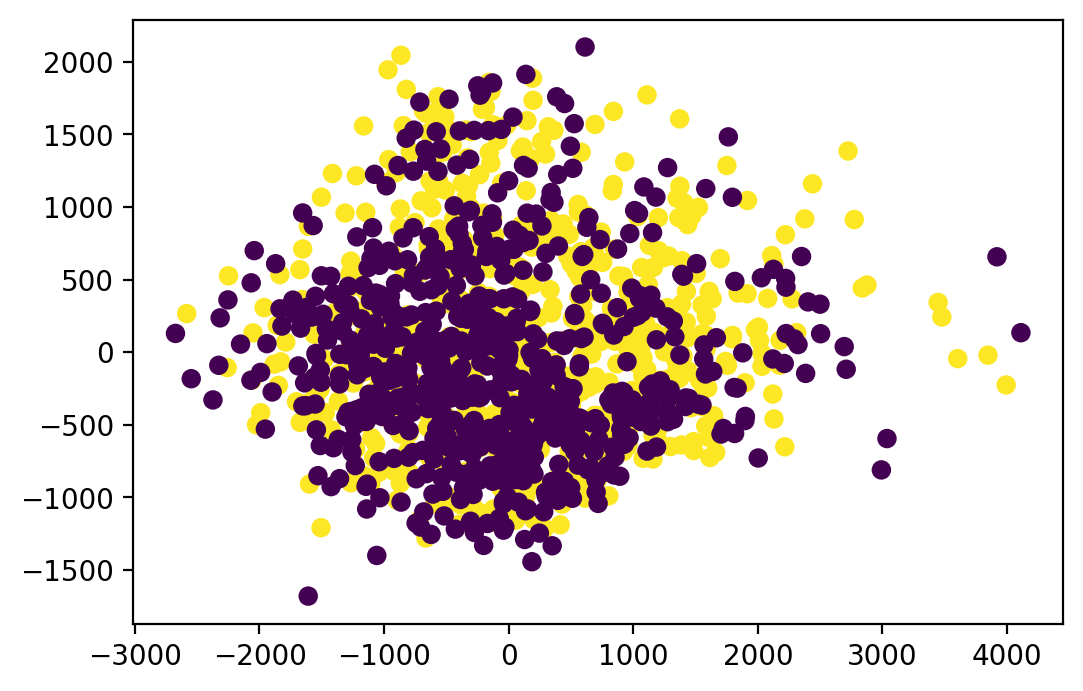

In [27]:
pca.n_components = 2
pca_data = pca.fit_transform(mfccs_reshaped)

plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = labels)
plt.show()

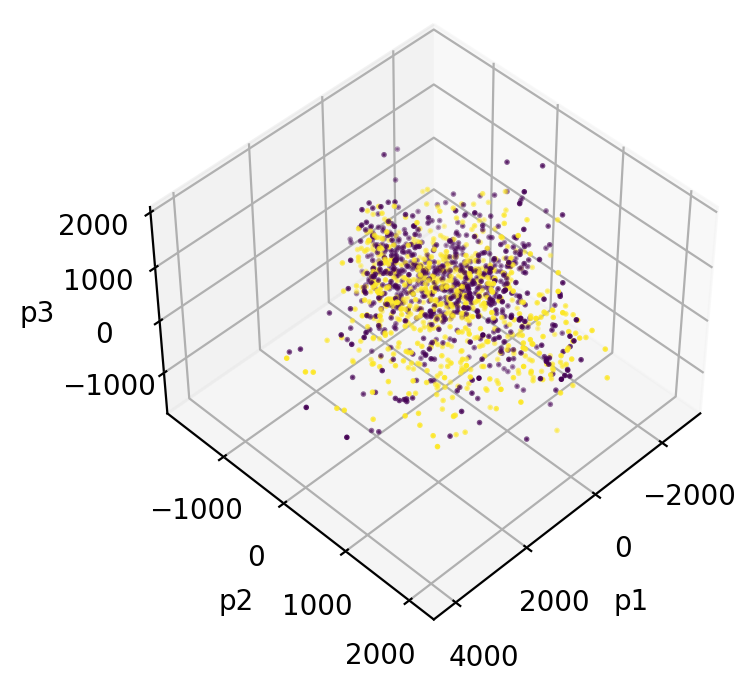

In [46]:
pca.n_components = 3
pca_data = pca.fit_transform(mfccs_reshaped)

fig = plt.figure(dpi = 200)
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c = labels, s = 1)
ax.set_xlabel("p1")
ax.set_ylabel("p2")
ax.set_zlabel("p3")

ax.view_init(45, 45)

plt.show()

In [ ]:
mfccs = np.asarray(mfccs)

PCA of MFCC (Coswara)

In [9]:
### Setup paths and directories
dataset_path = r"dataset/Coswara-Data/preprocess4"
# rawdata_path = os.path.join(dataset_path, "raw")
# metadata_path = os.path.join(dataset_path, "metadata.csv")

In [76]:
with open(os.path.join(dataset_path, "mfcc_fixlength_144000_nmfcc_15_nfft_1024_hoplength_512.pkl"), "rb") as f:
    mfcc = pickle.load(f)

In [77]:
mfccs = []
labels = []
for mfcc, label in list(mfcc.values()):
    mfccs.append(mfcc)
    labels.append(label)

In [78]:
mfccs = np.asarray(mfccs)
mfccs_reshaped = mfccs.reshape(mfccs.shape[0], -1)
mfccs.shape

(1182, 282, 15)

In [10]:
filepath = "cropped_30720.pkl"
with open(os.path.join(dataset_path, filepath), "rb") as f:
    signal_data = pickle.load(f)

In [15]:
mfccs = np.load(os.path.join(dataset_path, "mfcc39_fixlength_30720_nmfcc_39_framelength_2048_hoplength_1024.npy"))
mfccs_reshaped = mfccs.reshape(mfccs.shape[0], -1)

In [25]:
mfccs_reshaped = np.mean(mfccs, axis = 2)

In [13]:
labels = np.asarray(signal_data["label"])

In [14]:
pca = decomposition.PCA()

Text(0.5, 1.0, 'PCA explained variance ratio')

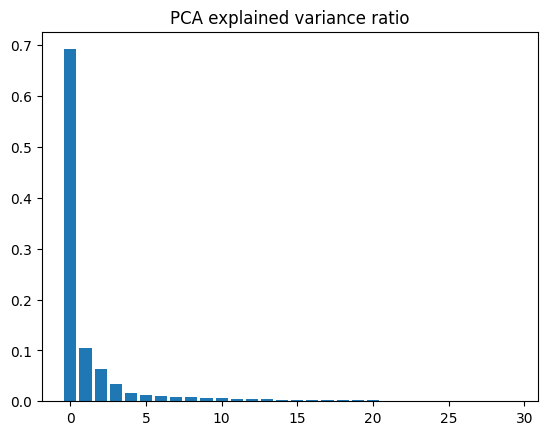

In [26]:
pca.n_components = 30
pca_data = pca.fit_transform(mfccs_reshaped)
pca_ratio = pca.explained_variance_ratio_
plt.bar(np.arange(len(pca_ratio)), pca_ratio)
plt.title("PCA explained variance ratio")

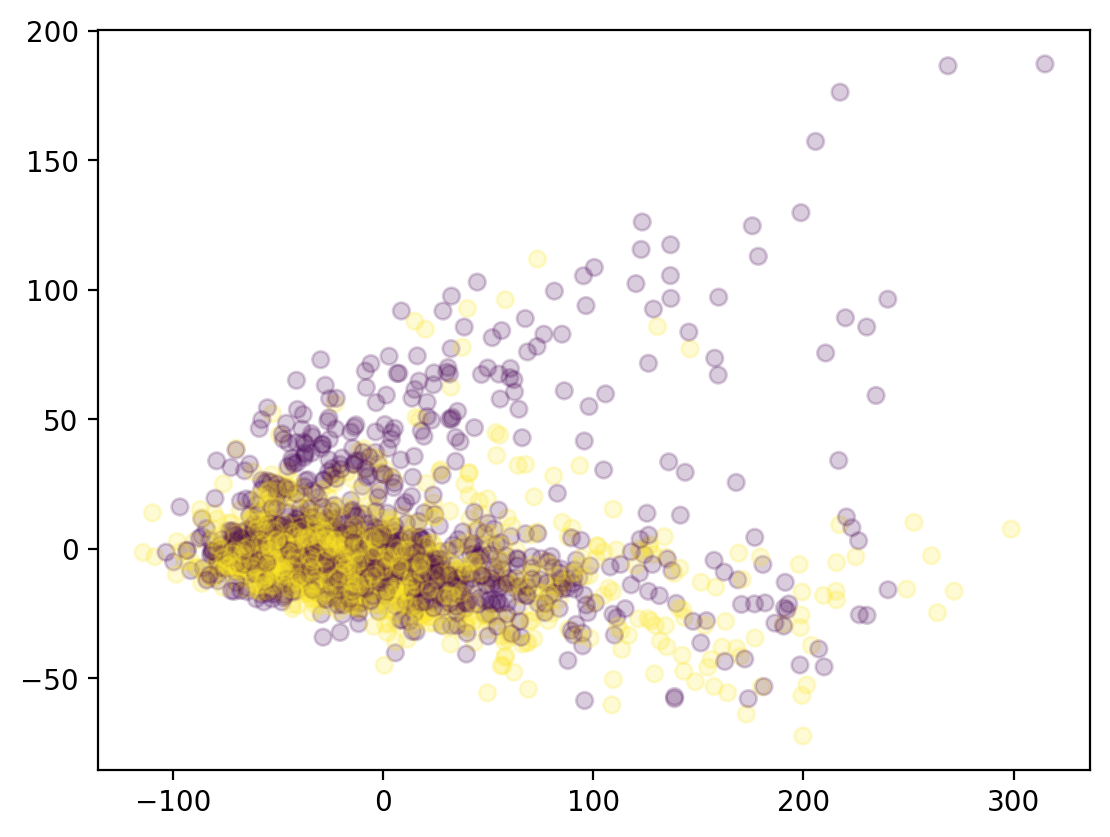

In [30]:
pca.n_components = 2
pca_data = pca.fit_transform(mfccs_reshaped)

plt.figure(dpi = 200)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = labels, alpha = 0.2)
plt.show()

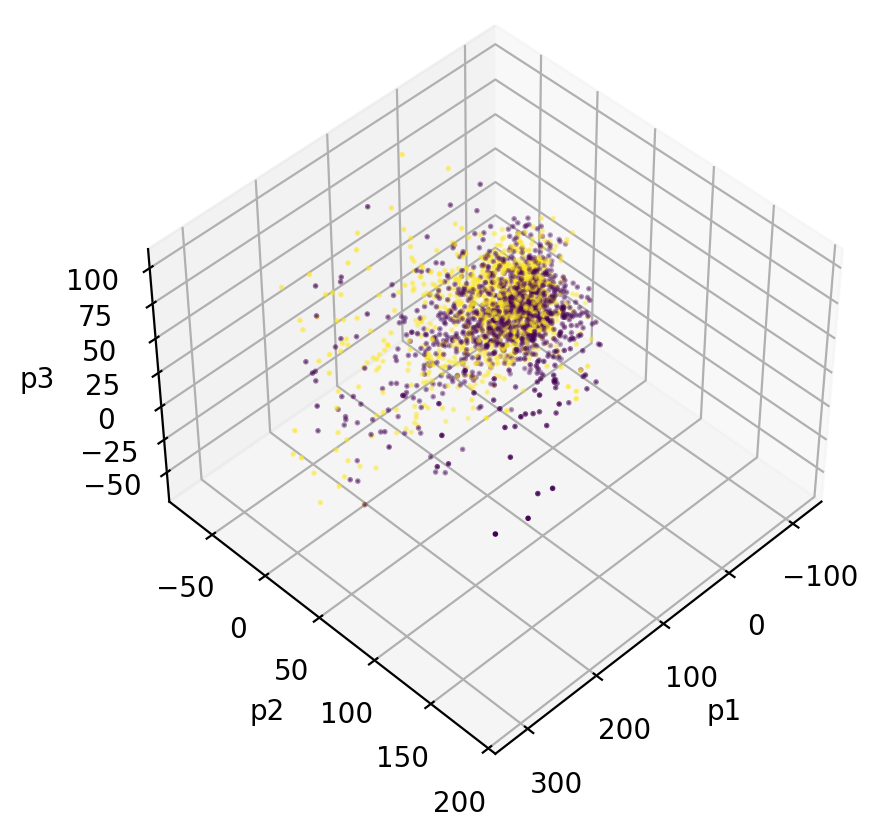

In [28]:
pca.n_components = 3
pca_data = pca.fit_transform(mfccs_reshaped)

fig = plt.figure(dpi = 200)
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c = labels, s = 1)
ax.set_xlabel("p1")
ax.set_ylabel("p2")
ax.set_zlabel("p3")

ax.view_init(45, 45)

plt.show()

t-SNE of russian dataset

In [87]:
# Set dataset path
datasetPath = r"dataset/Russian-dataset"
rawDataPath = os.path.join(datasetPath, "raw")

In [88]:
mfcc = np.load(os.path.join(datasetPath, "mfcc_300000_resampled.npy"))
labels = np.load(os.path.join(datasetPath, "covid_status.npy"))

In [89]:
mfcc_reshaped = mfcc.reshape(mfcc.shape[0], -1)

In [95]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)

tsne_data = model.fit_transform(mfcc_reshaped)

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


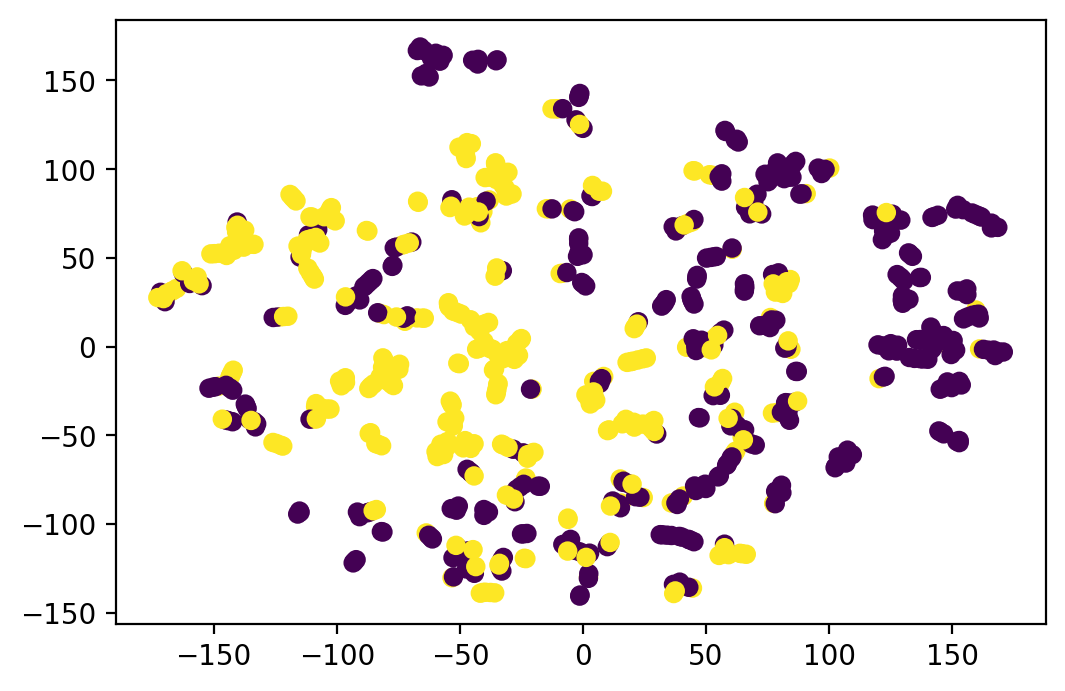

In [96]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)
tsne_data = model.fit_transform(mfcc_reshaped)

plt.figure(dpi = 200)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = labels)
plt.show()

t-SNE of COUGHVID

In [97]:
### Setup paths and directories
dataset_path = r"dataset/COUGHVID/preprocess2/"
rawdata_path = os.path.join(dataset_path, "raw")
metadata_path = os.path.join(dataset_path, "metadata.csv")

In [98]:
with open(os.path.join(dataset_path, "mfcc_fixlength_48000_nmfcc_15_nfft_1024_hoplength_512.pkl"), "rb") as f:
    mfcc = pickle.load(f)

In [99]:
mfccs = []
labels = []
for mfcc, label in list(mfcc.values()):
    mfccs.append(mfcc)
    labels.append(label)

In [100]:
mfccs = np.asarray(mfccs)

In [101]:
mfccs_reshaped = mfccs.reshape(mfccs.shape[0], -1)

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


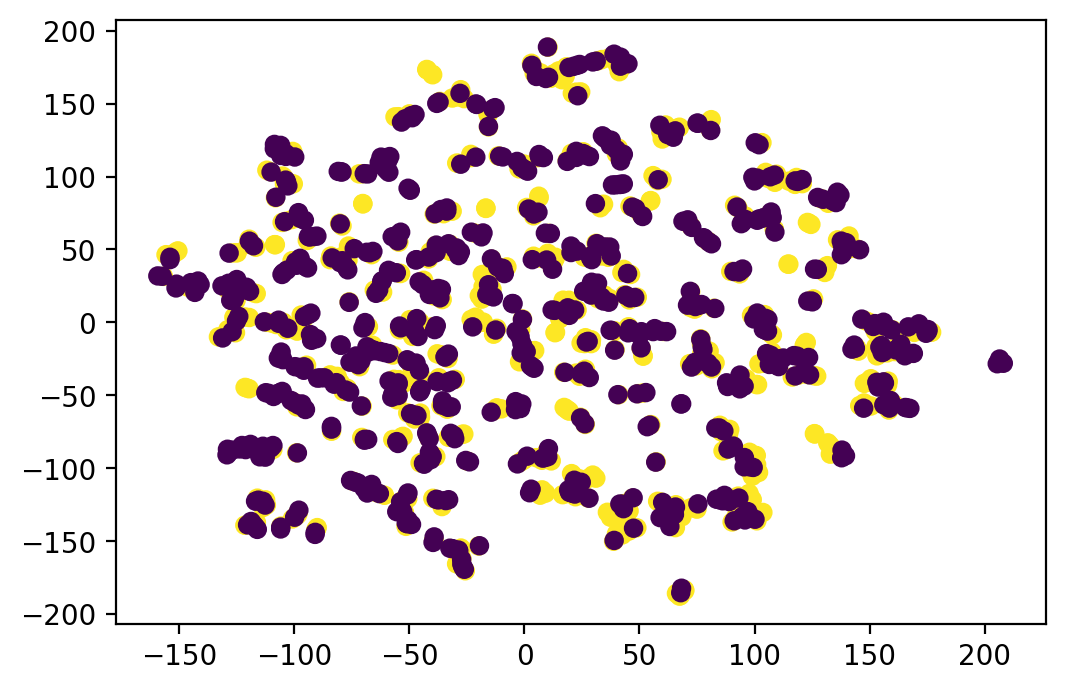

In [102]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)
tsne_data = model.fit_transform(mfccs_reshaped)

plt.figure(dpi = 200)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = labels)
plt.show()

t-SNE of Coswara

In [103]:
### Setup paths and directories
dataset_path = r"dataset\Coswara-Data\preprocess1"
# rawdata_path = os.path.join(dataset_path, "raw")
# metadata_path = os.path.join(dataset_path, "metadata.csv")

In [104]:
with open(os.path.join(dataset_path, "mfcc_fixlength_144000_nmfcc_15_nfft_1024_hoplength_512.pkl"), "rb") as f:
    mfcc = pickle.load(f)

In [105]:
mfccs = []
labels = []
for mfcc, label in list(mfcc.values()):
    mfccs.append(mfcc)
    labels.append(label)

In [107]:
mfccs = np.asarray(mfccs)
mfccs_reshaped = mfccs.reshape(mfccs.shape[0], -1)
mfccs_reshaped.shape

(1182, 4230)

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


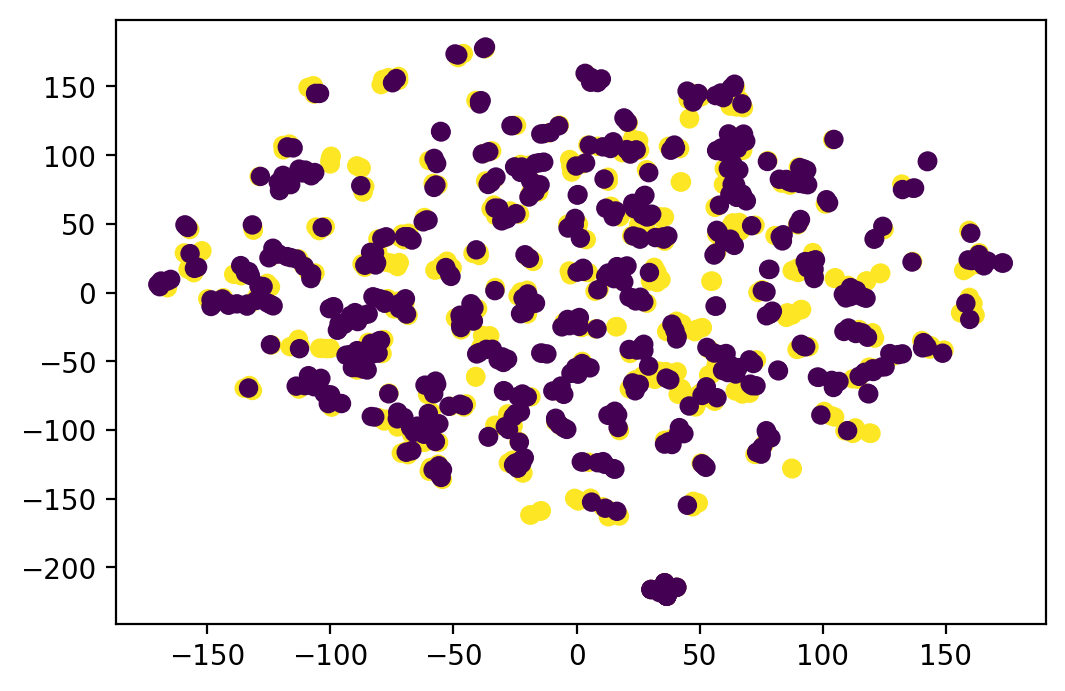

In [108]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity = 2, n_iter = 5000)
tsne_data = model.fit_transform(mfccs_reshaped)

plt.figure(dpi = 200)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = labels)
plt.show()